# 5 Deep Markov Model

In [1]:
import torch
import torch.nn as nn
import pyro
import pyro.distributions as D
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
from pyro import poutine
from pyro.optim import ClippedAdam
from pyro.infer import SVI, TraceMeanField_ELBO
import numpy as np
import time


In [2]:
import pyro.contrib.examples.polyphonic_data_loader as poly

In [3]:
data = poly.load_data(poly.JSB_CHORALES)

In [4]:
data['train']['sequence_lengths'].shape, data['train']['sequences'].shape

(torch.Size([229]), torch.Size([229, 129, 88]))

In [5]:
class Emitter(nn.Module):
    def __init__(self, input_dim, z_dim, emission_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(z_dim, emission_dim), nn.ReLU(),
            nn.Linear(emission_dim, emission_dim), nn.ReLU(),
            nn.Linear(emission_dim, input_dim)
        )
        
    def forward(self, z):
        return torch.sigmoid(self.model(z))

In [6]:
class GatedTransition(nn.Module):
    def __init__(self, z_dim, trans_dim):
        super().__init__()
        self.gate = nn.Sequential(
            nn.Linear(z_dim, trans_dim), nn.ReLU(),
            nn.Linear(trans_dim, z_dim), nn.Sigmoid()
        )
        self.mean = nn.Sequential(
            nn.Linear(z_dim, trans_dim), nn.ReLU(),
            nn.Linear(trans_dim, z_dim)
        )
        self.loc = nn.Linear(z_dim, z_dim)
        self.scale = nn.Linear(z_dim, z_dim)
        
        self.loc.weight.data = torch.eye(z_dim)
        self.loc.bias.data = torch.zeros(z_dim)
        
        self.relu = nn.ReLU()
        self.softplus = nn.Softplus()
        
        
    def forward(self, z):
        gate = self.gate(z)
        proposed_mean = self.mean(z)
        loc = (1 - gate) * self.loc(z) + gate * proposed_mean
        scale = self.softplus(self.scale(self.relu(proposed_mean)))
        return loc, scale 
    

In [31]:
def _model(self, minibatch, mini_batch_reversed, mini_batch_mask,
          mini_batch_seq_lenghts, annealing_factor=1.):
    Tmax = minibatch.size(1)
    
    pyro.module('dmm', self)
    
    z_prev = self.z0.expand(minibatch.size(0), self.z0.size(0))
    
    with pyro.plate('z_minibatch', len(minibatch)):
        
        for t in pyro.markov(range(1, Tmax + 1)):
            z_loc, z_scale = self.trans(z_prev)
            
            with poutine.scale(None, annealing_factor):
                z_t = pyro.sample(f'z_{t}', 
                                  D.Normal(z_loc, z_scale)
                                    .mask(mini_batch_mask[:, t-1:t])
                                    .to_event(1))
                
            emission_probs_t = self.emitter(z_t)

            
            pyro.sample(f'obs_{t}', 
                        D.Bernoulli(emission_probs_t)
                            #.mask(mini_batch_mask[: t-1:t])
                            .to_event(1),
                        obs=minibatch[:, t-1, :])
            
            z_prev = z_t
                

In [46]:
class Combiner(nn.Module):
    def __init__(self, z_dim, rnn_dim):
        super().__init__()
        self.z_to_hidden = nn.Linear(z_dim, rnn_dim)
        self.hidden_to_loc = nn.Linear(rnn_dim, z_dim)
        self.hidden_to_scale = nn.Linear(rnn_dim, z_dim)
        
        self.tanh = nn.Tanh()
        self.softplus =  nn.Softplus()
        
    def forward(self, z_t_1, h_rnn):
        h_comb = 0.5 * (self.tanh(self.z_to_hidden(z_t_1)) + h_rnn)
        loc = self.hidden_to_loc(h_comb)
        scale = self.softplus(self.hidden_to_scale(h_comb)) + 1e-9
        return loc, scale

In [47]:
def _guide(self, minibatch, minibatch_reversed, minibatch_mask,
          minibatch_seq_lenghts, annealing_factor=1.):
    
    Tmax = minibatch.size(1)
    
    pyro.module('dmm', self)
    
    h0_contig = self.h0.expand(1, minibatch.size(0), self.rnn.hidden_size).contiguous()

    rnn_out, _ = self.rnn(minibatch_reversed, h0_contig)
    
    rnn_out = poly.pad_and_reverse(rnn_out, minibatch_seq_lenghts)
    
    z_prev = self.zq0.expand(minibatch.size(0), self.zq0.size(0))
    
    
    with pyro.plate('z_minibatch', len(minibatch)):
        for t in pyro.markov(range(1, Tmax + 1)):
            z_loc, z_scale = self.combiner(z_prev, rnn_out[:, t-1, :])
            z_dist = D.Normal(z_loc, z_scale)
            
            with poutine.scale(None, annealing_factor):
                z_t = pyro.sample(f'z_{t}',
                                  z_dist.mask(minibatch_mask[:, t-1:t])
                                  .to_event(1))
                
            z_prev = z_t 
            
            

In [48]:
class DMM(nn.Module):
    def __init__(self, input_dim=88, z_dim=100, emission_dim=100, 
                 trans_dim=200, rnn_dim=500, rnn_dropout=0.0,
                 num_iafs=0, iaf_dim=50):
        super().__init__()
        self.emitter = Emitter(input_dim, z_dim, emission_dim)
        self.trans = GatedTransition(z_dim, trans_dim)
        self.combiner = Combiner(z_dim, rnn_dim)
        self.rnn = nn.RNN(input_dim, rnn_dim, nonlinearity='relu', batch_first=True,
                          bidirectional=False, num_layers=1, dropout=rnn_dropout)
        
        self.z0 = nn.Parameter(torch.zeros(z_dim))
        self.zq0 = nn.Parameter(torch.zeros(z_dim))
        self.h0 = nn.Parameter(torch.zeros(1, 1, rnn_dim))
        
    def model(self, minibatch, mini_batch_reversed, mini_batch_mask,
            mini_batch_seq_lenghts, annealing_factor=1.):
        _model(self, minibatch, mini_batch_reversed, mini_batch_mask,
          mini_batch_seq_lenghts, annealing_factor)
        
    def guide(self, minibatch, mini_batch_reversed, mini_batch_mask,
          mini_batch_seq_lenghts, annealing_factor=1.):
        _guide(self, minibatch, mini_batch_reversed, mini_batch_mask,
          mini_batch_seq_lenghts, annealing_factor)

In [49]:
dmm = DMM()
adam_params = {'lr': 3e-4, 'betas': (0.96, 0.999), 'clip_norm': 10.,
               'lrd': 0.99996, 'weight_decay': 2.}
optimizer = ClippedAdam(adam_params)

In [50]:
svi = SVI(dmm.model, dmm.guide, optimizer, TraceMeanField_ELBO())

In [51]:
training_seq_lengths = data['train']['sequence_lengths']
training_data_sequences = data['train']['sequences']
test_seq_lengths = data['test']['sequence_lengths']
test_data_sequences = data['test']['sequences']
val_seq_lengths = data['valid']['sequence_lengths']
val_data_sequences = data['valid']['sequences']
N_train_data = len(training_seq_lengths)
N_train_time_slices = training_seq_lengths.sum().item()
N_mini_batches = int(N_train_data / 20 +
                     int(N_train_data % 20 > 0))

In [52]:
annealing_epochs = 1000
minimum_annealing_factor = 0.2

In [53]:
def process_minibatch(epoch, which_mini_batch, shuffled_indices):
    if annealing_epochs > 0 and epoch < annealing_epochs:
        # compute the KL annealing factor appropriate
        # for the current mini-batch in the current epoch
        min_af = minimum_annealing_factor
        annealing_factor = min_af + (1.0 - min_af) * \
            (float(which_mini_batch + epoch * N_mini_batches + 1) /
             float(annealing_epochs * N_mini_batches))
    else:
        # by default the KL annealing factor is unity
        annealing_factor = 1.0

    # compute which sequences in the training set we should grab
    mini_batch_start = (which_mini_batch * 20)
    mini_batch_end = np.min([(which_mini_batch + 1) * 20,
                             N_train_data])
    mini_batch_indices = shuffled_indices[mini_batch_start:mini_batch_end]
    # grab the fully prepped mini-batch using the helper function in the data loader
    mini_batch, mini_batch_reversed, mini_batch_mask, mini_batch_seq_lengths \
        = poly.get_mini_batch(mini_batch_indices, training_data_sequences,
                              training_seq_lengths)
    # do an actual gradient step
    loss = svi.step(mini_batch, mini_batch_reversed, mini_batch_mask,
                     mini_batch_seq_lengths, annealing_factor)
    # keep track of the training loss
    return loss

In [54]:
n_eval_samples = 1

def rep(x):
    return np.repeat(x, n_eval_samples, axis=0)

# get the validation/test data ready for the dmm: pack into sequences, etc.
val_seq_lengths = rep(val_seq_lengths)
test_seq_lengths = rep(test_seq_lengths)
val_batch, val_batch_reversed, val_batch_mask, val_seq_lengths = poly.get_mini_batch(
    np.arange(n_eval_samples * val_data_sequences.shape[0]), rep(val_data_sequences),
    val_seq_lengths)
test_batch, test_batch_reversed, test_batch_mask, test_seq_lengths = \
    poly.get_mini_batch(np.arange(n_eval_samples * test_data_sequences.shape[0]),
                        rep(test_data_sequences),
                        test_seq_lengths)

In [55]:
def do_evaluation():
    # put the RNN into evaluation mode (i.e. turn off drop-out if applicable)
    dmm.rnn.eval()

    # compute the validation and test loss
    val_nll = svi.evaluate_loss(val_batch, val_batch_reversed, val_batch_mask,
                                 val_seq_lengths) / val_seq_lengths.sum()
    test_nll = svi.evaluate_loss(test_batch, test_batch_reversed, test_batch_mask,
                                  test_seq_lengths) / test_seq_lengths.sum()

    # put the RNN back into training mode (i.e. turn on drop-out if applicable)
    dmm.rnn.train()
    return val_nll, test_nll

In [59]:
from tqdm import trange

pyro.clear_param_store()
times = []
vals = []
tests = []

for epoch in trange(3000):
    # accumulator for our estimate of the negative log likelihood
    # (or rather -elbo) for this epoch
    epoch_nll = 0.0
    since = time.time()
    # prepare mini-batch subsampling indices for this epoch
    shuffled_indices = np.arange(N_train_data)
    np.random.shuffle(shuffled_indices)

    # process each mini-batch; this is where we take gradient steps
    for which_mini_batch in range(N_mini_batches):
        epoch_nll += process_minibatch(epoch, which_mini_batch, shuffled_indices)

    # report training diagnostics
    times.append(time.time() - since)
    val, test = do_evaluation()
    vals.append(val), tests.append(test)
    
    

100%|██████████| 3000/3000 [9:16:44<00:00, 11.13s/it]  


In [60]:
import matplotlib.pyplot as plt

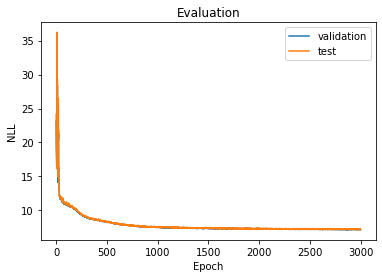

In [62]:
plt.plot(vals, label='validation')
plt.plot(tests, label='test')
plt.title('Evaluation')
plt.xlabel('Epoch')
plt.ylabel('NLL')
plt.legend()
plt.show()